In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/data/LOG_CHESTXRAY.pdf
/kaggle/input/data/README_CHESTXRAY.pdf
/kaggle/input/data/BBox_List_2017.csv
/kaggle/input/data/test_list.txt
/kaggle/input/data/ARXIV_V5_CHESTXRAY.pdf
/kaggle/input/data/Data_Entry_2017.csv
/kaggle/input/data/train_val_list.txt
/kaggle/input/data/FAQ_CHESTXRAY.pdf
/kaggle/input/data/images_003/images/00006199_010.png
/kaggle/input/data/images_003/images/00004833_016.png
/kaggle/input/data/images_003/images/00006260_000.png
/kaggle/input/data/images_003/images/00004911_010.png
/kaggle/input/data/images_003/images/00004186_007.png
/kaggle/input/data/images_003/images/00004459_000.png
/kaggle/input/data/images_003/images/00005004_001.png
/kaggle/input/data/images_003/images/00005757_000.png
/kaggle/input/data/images_003/images/00004221_001.png
/kaggle/input/data/images_003/images/00004875_000.png
/kaggle/input/data/images_003/images/00005448_001.png
/kaggle/input/data/images_003/images/00005572_000.png
/kaggle/input/data/images_003/images/00005271_00

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import time
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
from torchvision.models import densenet121, DenseNet121_Weights

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, log_loss

In [5]:
# %% config
CONFIG = {
    "model": "replication_of_dannynet_mc",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 7,
    "num_workers": 0,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/data",  # change if needed
    "patience": 5,
    "seed": 42,
    "image_size": 224,
    "mc_forward_passes": 30, 
}

In [6]:
print("Device:", CONFIG["device"])

Device: cuda


In [7]:
# %% transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(CONFIG["image_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [8]:
# %% model with dropout 
class MC_DenseNet(nn.Module):
    def __init__(self, base_model, dropout_p=0.2, num_classes=14):
        super(MC_DenseNet, self).__init__()
        self.features = base_model.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        # final dropout before classifier
        self.dropout = nn.Dropout(p=dropout_p)
        self.classifier = nn.Linear(base_model.classifier.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.relu(x, inplace=True)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [9]:
# build model
base_model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model = MC_DenseNet(base_model, dropout_p=0.2).to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 169MB/s]


In [10]:
# %% loss & optimizer
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        # inputs: logits
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [11]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [12]:
# %% data loading (unchanged)
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder

df = df[df['Image Index'].isin(image_to_folder.keys())]

unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=CONFIG["seed"])
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [13]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [14]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [15]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [16]:
# %% metrics helpers (ECE, brier, nll)
def expected_calibration_error_multi(y_true, y_prob, n_bins=15):
    """
    y_true, y_prob: numpy arrays [N, C]
    returns average ECE across classes (skips constant-label classes)
    """
    C = y_prob.shape[1]
    ece_list = []
    for i in range(C):
        t = y_true[:, i]
        p = y_prob[:, i]
        if len(np.unique(t)) == 1:
            continue
        bins = np.linspace(0.0, 1.0, n_bins + 1)
        ece = 0.0
        for b in range(n_bins):
            mask = (p > bins[b]) & (p <= bins[b+1])
            if mask.sum() == 0:
                continue
            conf = p[mask].mean()
            acc = (t[mask] == (p[mask] >= 0.5).astype(int)).mean()
            ece += (mask.mean()) * abs(acc - conf)
        ece_list.append(ece)
    return float(np.mean(ece_list)) if ece_list else float('nan')

def brier_score_multi(y_true, y_prob):
    """Mean Brier across classes (skip constant-label classes)."""
    C = y_prob.shape[1]
    brier_list = []
    for i in range(C):
        t = y_true[:, i]
        p = y_prob[:, i]
        if len(np.unique(t)) == 1:
            continue
        brier_list.append(np.mean((p - t)**2))
    return float(np.mean(brier_list)) if brier_list else float('nan')

def nll_multi(y_true, y_prob):
    """Mean NLL (log_loss) across classes where possible."""
    C = y_prob.shape[1]
    nll_list = []
    for i in range(C):
        t = y_true[:, i]
        p = y_prob[:, i]
        if len(np.unique(t)) == 1:
            continue
        # clip tiny values to avoid log-loss errors
        try:
            nll_list.append(log_loss(t, p, eps=1e-7))
        except Exception:
            continue
    return float(np.mean(nll_list)) if nll_list else float('nan')

In [17]:
# %% enable only dropout helper
def enable_dropout(model):
    """Put model in eval mode, then enable dropout layers."""
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

In [18]:
# %% MC dropout - collect logits, compute mean logits & mean probs & var probs
def mc_logits_predict(model, inputs, mc_passes=CONFIG["mc_forward_passes"], device=CONFIG["device"]):
    """
    Collect mc_passes stochastic forward passes of logits (no sigmoid).
    Returns:
      mean_logits: [B, C]
      mean_probs: [B, C]
      var_probs:  [B, C] variance across MC samples of probabilities
    """
    model.eval()
    enable_dropout(model)  # BN frozen, dropout active

    logits_list = []
    with torch.no_grad():
        for _ in range(mc_passes):
            logits = model(inputs)  # logits tensor
            logits_list.append(logits.cpu().numpy())

    logits_arr = np.stack(logits_list, axis=0)  # [T, B, C]
    mean_logits = logits_arr.mean(axis=0)       # [B, C]
    # compute probabilities per-sample per-pass, then var across passes
    probs_arr = 1.0 / (1.0 + np.exp(-logits_arr))  # sigmoid
    mean_probs = probs_arr.mean(axis=0)           # [B, C]
    var_probs = probs_arr.var(axis=0)             # [B, C]
    return mean_logits, mean_probs, var_probs


In [19]:
# %% get thresholds helper 
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
# %% evaluate with MC Dropout
def evaluate_mc(model, loader, criterion, device, mc_passes=CONFIG["mc_forward_passes"], desc="[Eval-MC]"):
    model.to(device)
    model.eval()  # ensures BatchNorm uses running stats
    running_loss = 0.0
    all_labels, all_mean_probs, all_var_probs, all_mean_logits = [], [], [], []

    for inputs, labels in tqdm(loader, desc=desc):
        inputs, labels = inputs.to(device), labels.to(device)

        # MC sampling (returns logits & probs)
        mean_logits, mean_probs, var_probs = mc_logits_predict(model, inputs, mc_passes=mc_passes, device=device)

        # compute loss on mean_logits (criterion expects logits)
        mean_logits_tensor = torch.tensor(mean_logits, dtype=torch.float32).to(device)
        loss = criterion(mean_logits_tensor, labels)
        running_loss += loss.item()

        all_labels.append(labels.cpu().numpy())
        all_mean_probs.append(mean_probs)
        all_var_probs.append(var_probs)
        all_mean_logits.append(mean_logits)

    all_labels = np.vstack(all_labels)           # [N, C]
    all_mean_probs = np.vstack(all_mean_probs)   # [N, C]
    all_var_probs = np.vstack(all_var_probs)     # [N, C]
    all_mean_logits = np.vstack(all_mean_logits) # [N, C]

    # thresholds & predicted binaries (use mean_probs)
    thresholds = get_optimal_thresholds(all_labels, all_mean_probs)
    preds_binary = np.zeros_like(all_mean_probs, dtype=int)
    for i in range(all_mean_probs.shape[1]):
        preds_binary[:, i] = (all_mean_probs[:, i] > thresholds[i]).astype(int)

    # per-class metrics
    auc_scores = []
    f1_scores = []
    for i in range(all_mean_probs.shape[1]):
        try:
            auc_scores.append(roc_auc_score(all_labels[:, i], all_mean_probs[:, i]))
        except ValueError:
            auc_scores.append(float('nan'))
        f1_scores.append(f1_score(all_labels[:, i], preds_binary[:, i], zero_division=0))

    auc_dict = dict(zip(disease_list, auc_scores))
    f1_dict = dict(zip(disease_list, f1_scores))
    thresholds_dict = dict(zip(disease_list, thresholds))

    avg_auc = float(np.nanmean(auc_scores))
    avg_f1 = float(np.nanmean(f1_scores))

    # calibration metrics
    ece = expected_calibration_error_multi(all_labels, all_mean_probs, n_bins=15)
    brier = brier_score_multi(all_labels, all_mean_probs)
    nll = nll_multi(all_labels, all_mean_probs)

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": auc_dict,
        "f1_dict": f1_dict,
        "thresholds": thresholds_dict,
        "mean_preds": all_mean_probs,
        "var_preds": all_var_probs,
        "logits": all_mean_logits,
        "labels": all_labels,
        "ece": ece,
        "brier": brier,
        "nll": nll
    }


In [21]:
# %% risk-coverage helper (selective prediction)
def risk_coverage(y_true, y_prob, y_unc, thresholds, coverages=[1.0, 0.9, 0.8, 0.7, 0.6, 0.5]):
    """
    y_true: [N,C], y_prob: [N,C], y_unc: [N,C] (per-class variance)
    thresholds: dict class->thr
    returns dict coverage->risk
    """
    sample_unc = y_unc.mean(axis=1)  # scalar per-sample
    order = np.argsort(sample_unc)   # least uncertain first
    N = len(sample_unc)

    preds_bin = np.zeros_like(y_prob, dtype=int)
    cls_list = list(thresholds.keys())
    for i, cls in enumerate(cls_list):
        preds_bin[:, i] = (y_prob[:, i] >= thresholds[cls]).astype(int)

    # here correctness per sample = all class labels match predicted bin (strict)
    correct_per_sample = (preds_bin == y_true).all(axis=1).astype(int)

    results = {}
    for cov in coverages:
        k = max(1, int(np.round(cov * N)))
        idx_keep = order[:k]
        risk = 1.0 - correct_per_sample[idx_keep].mean()
        results[float(cov)] = float(risk)
    return results

In [22]:
# %% train / validate / main loop 
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss

def validate(model, valloader, criterion, device):
    return evaluate_mc(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# %% main loop
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

for epoch in range(CONFIG["epochs"]):
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    scheduler.step(val_stats["loss"])

    print(f"\nEpoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_stats['loss']:.4f} | Val AUROC: {val_stats['avg_auc']:.4f} | ECE: {val_stats['ece']:.4f}")

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved new best model at {checkpoint_path}")
    else:
        patience_counter += 1
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

Epoch 1/7 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]


Epoch 1 | Train Loss: 0.0480 | Val Loss: 0.0426 | Val AUROC: 0.8016 | ECE: 0.7382
Saved new best model at models/best_model_20250912-093449.pth


Epoch 2/7 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]


Epoch 2 | Train Loss: 0.0448 | Val Loss: 0.0413 | Val AUROC: 0.8142 | ECE: 0.7527
Saved new best model at models/best_model_20250912-110038.pth


Epoch 3/7 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]


Epoch 3 | Train Loss: 0.0438 | Val Loss: 0.0415 | Val AUROC: 0.8154 | ECE: 0.7517
Saved new best model at models/best_model_20250912-122322.pth


Epoch 4/7 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]


Epoch 4 | Train Loss: 0.0432 | Val Loss: 0.0404 | Val AUROC: 0.8312 | ECE: 0.7620
Saved new best model at models/best_model_20250912-134548.pth


Epoch 5/7 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]


Epoch 5 | Train Loss: 0.0428 | Val Loss: 0.0399 | Val AUROC: 0.8367 | ECE: 0.7561
Saved new best model at models/best_model_20250912-150810.pth


Epoch 6/7 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]


Epoch 6 | Train Loss: 0.0424 | Val Loss: 0.0408 | Val AUROC: 0.8371 | ECE: 0.7598
Saved new best model at models/best_model_20250912-162750.pth


Epoch 7/7 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]


Epoch 7 | Train Loss: 0.0422 | Val Loss: 0.0398 | Val AUROC: 0.8399 | ECE: 0.7688
Saved new best model at models/best_model_20250912-174831.pth


In [24]:
# %% test & print results
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate_mc(model, testloader, criterion, CONFIG["device"])

[Eval-MC]:   0%|          | 0/288 [00:00<?, ?it/s]

In [25]:
print("\n===== TEST RESULTS =====")
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")
print(f"ECE       : {test_stats['ece']:.6f}")
print(f"Brier     : {test_stats['brier']:.6f}")
print(f"NLL       : {test_stats['nll']:.6f}")

print("\n=== Per-Class Metrics ===")
print("{:<24} {:<10} {:<10} {:<10} {:<12}".format("Class", "AUROC", "F1", "Thr", "Unc(mean)"))
print("-" * 70)
for i, cls in enumerate(disease_list):
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    unc = test_stats['var_preds'][:, i].mean()  # mean variance across samples
    print("{:<24} {:<10.4f} {:<10.4f} {:<10.4f} {:<12.6f}".format(cls, auc, f1, thr, unc))

avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))

# Risk-coverage example
rc = risk_coverage(test_stats['labels'], test_stats['mean_preds'], test_stats['var_preds'], test_stats['thresholds'],
                   coverages=[1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
print("\nRisk-Coverage (coverage -> risk):")
for cov, risk in rc.items():
    print(f"{cov:.2f} -> {risk:.4f}")


===== TEST RESULTS =====
Loss      : 0.0426
Avg AUROC : 0.8362
Avg F1    : 0.3713
ECE       : 0.758755
Brier     : 0.063075
NLL       : 0.252565

=== Per-Class Metrics ===
Class                    AUROC      F1         Thr        Unc(mean)   
----------------------------------------------------------------------
Atelectasis              0.7929     0.3794     0.3553     0.000287    
Cardiomegaly             0.9115     0.5034     0.3294     0.000322    
Consolidation            0.7745     0.2404     0.3052     0.000218    
Edema                    0.8841     0.2667     0.4061     0.000317    
Effusion                 0.8938     0.5847     0.4331     0.000345    
Emphysema                0.9533     0.5161     0.3860     0.000191    
Fibrosis                 0.7993     0.1091     0.3470     0.000199    
Hernia                   0.9984     0.7059     0.3306     0.000099    
Infiltration             0.6996     0.4128     0.3844     0.000221    
Mass                     0.8859     0.4385    

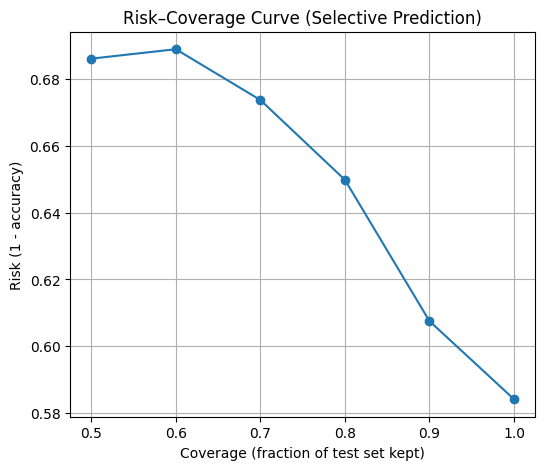

In [26]:
import matplotlib.pyplot as plt

# risk-coverage plot
coverages = list(rc.keys())
risks = list(rc.values())

plt.figure(figsize=(6,5))
plt.plot(coverages, risks, marker='o')
plt.title("Risk–Coverage Curve (Selective Prediction)")
plt.xlabel("Coverage (fraction of test set kept)")
plt.ylabel("Risk (1 - accuracy)")
plt.grid(True)
plt.show()


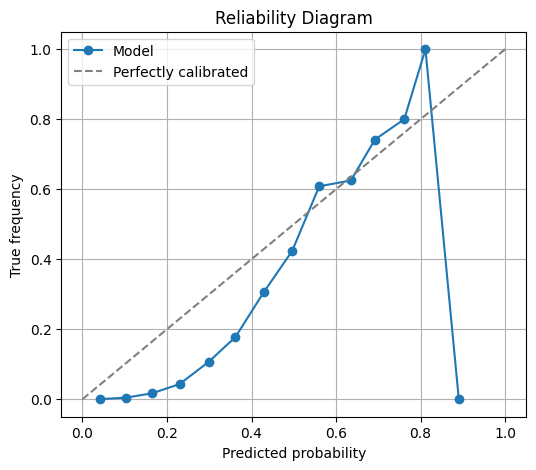

In [27]:
from sklearn.calibration import calibration_curve

# flatten across all classes
y_true_flat = test_stats["labels"].ravel()
y_prob_flat = test_stats["mean_preds"].ravel()

prob_true, prob_pred = calibration_curve(y_true_flat, y_prob_flat, n_bins=15)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="Perfectly calibrated")
plt.title("Reliability Diagram")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.legend()
plt.grid(True)
plt.show()


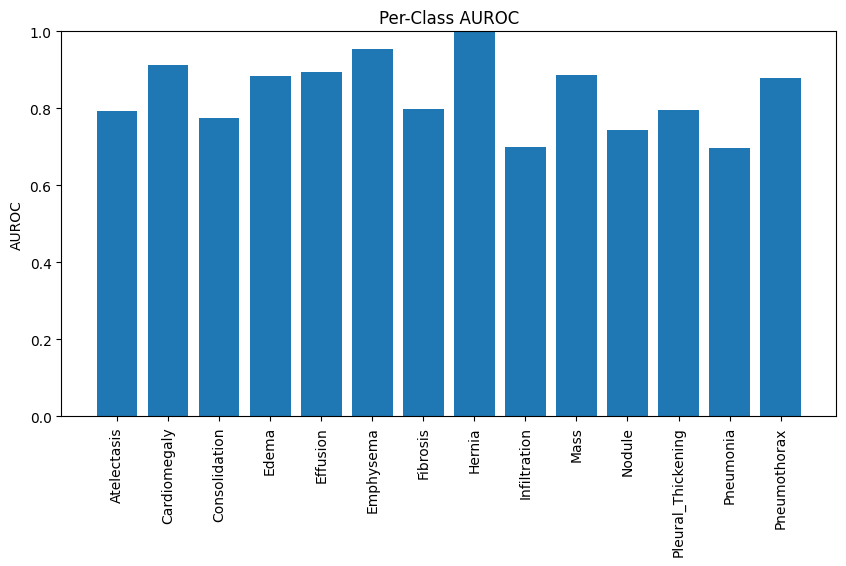

In [28]:
plt.figure(figsize=(10,5))
plt.bar(range(len(disease_list)), test_stats["auc_dict"].values())
plt.xticks(range(len(disease_list)), disease_list, rotation=90)
plt.ylabel("AUROC")
plt.title("Per-Class AUROC")
plt.ylim(0,1)
plt.show()


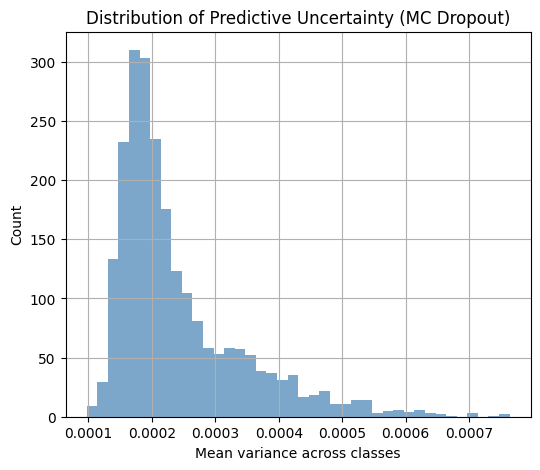

In [29]:
uncertainties = test_stats["var_preds"].mean(axis=1)  # average variance per sample

plt.figure(figsize=(6,5))
plt.hist(uncertainties, bins=40, alpha=0.7, color='steelblue')
plt.title("Distribution of Predictive Uncertainty (MC Dropout)")
plt.xlabel("Mean variance across classes")
plt.ylabel("Count")
plt.grid(True)
plt.show()


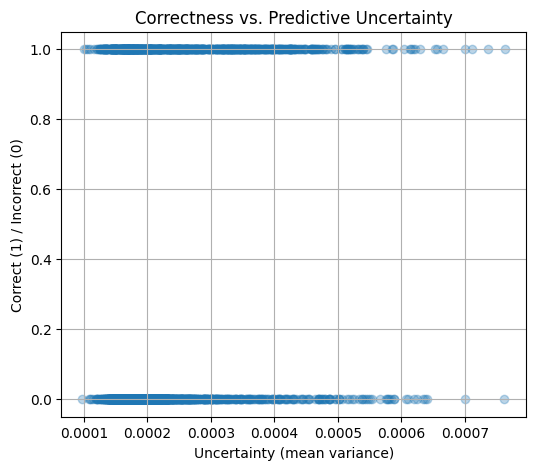

In [30]:
sample_unc = uncertainties
sample_correct = ( (test_stats["mean_preds"] >= 
                    np.array([list(test_stats["thresholds"].values())])).astype(int) 
                   == test_stats["labels"]).all(axis=1).astype(int)

plt.figure(figsize=(6,5))
plt.scatter(sample_unc, sample_correct, alpha=0.3)
plt.xlabel("Uncertainty (mean variance)")
plt.ylabel("Correct (1) / Incorrect (0)")
plt.title("Correctness vs. Predictive Uncertainty")
plt.grid(True)
plt.show()
